In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

#Working over data
data = pd.read_csv('downloads/MSFT.csv')
from sklearn.preprocessing import MinMaxScaler
price = data[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price['Close']

/Users/mac/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


0     -0.054303
1     -0.053391
2     -0.105595
3     -0.212011
4     -0.352560
         ...   
248    0.960391
249    0.990873
250    1.000000
251    0.976453
252    0.985580
Name: Close, Length: 253, dtype: float64

In [2]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [3]:
import torch
import torch.nn as nn
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [4]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 500

In [5]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h2 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c2 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h2.detach(), c2.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [6]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []
for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.1480269432067871
Epoch  1 MSE:  0.13169318437576294
Epoch  2 MSE:  0.1070401519536972
Epoch  3 MSE:  0.06778974086046219
Epoch  4 MSE:  0.029714496806263924
Epoch  5 MSE:  0.07205788791179657
Epoch  6 MSE:  0.023834072053432465
Epoch  7 MSE:  0.019276075065135956
Epoch  8 MSE:  0.026594333350658417
Epoch  9 MSE:  0.03332202136516571
Epoch  10 MSE:  0.034538377076387405
Epoch  11 MSE:  0.030032355338335037
Epoch  12 MSE:  0.02226448617875576
Epoch  13 MSE:  0.015702102333307266
Epoch  14 MSE:  0.014310373924672604
Epoch  15 MSE:  0.016625460237264633
Epoch  16 MSE:  0.019499599933624268
Epoch  17 MSE:  0.020187506452202797
Epoch  18 MSE:  0.01677679270505905
Epoch  19 MSE:  0.012774832546710968
Epoch  20 MSE:  0.01171425823122263
Epoch  21 MSE:  0.013165464624762535
Epoch  22 MSE:  0.014729880727827549
Epoch  23 MSE:  0.015041859820485115
Epoch  24 MSE:  0.014299488626420498
Epoch  25 MSE:  0.013151261024177074
Epoch  26 MSE:  0.012010226026177406
Epoch  27 MSE:  0.0111

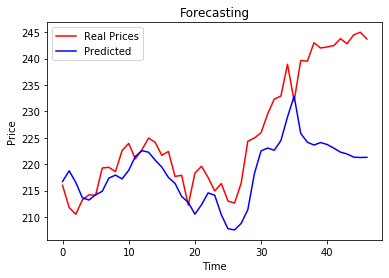

In [8]:
predicted_stock_price = model(x_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price.detach().numpy())

#Checking the results
plt.plot(scaler.inverse_transform(y_test), color = 'red', label = 'Real Prices')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted')
plt.title('Forecasting')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [9]:
def forecast(model,days,seed):
  forecast_values = []
  for i in range(days):
    pred = model(seed).detach().numpy()[0][0]
    forecast_values.append(pred)
    seed = torch.tensor(np.append(seed[:,1:][0],pred).reshape(1, 19, 1))
  return forecast_values


In [10]:
# 5 future values 
seed = x_test[-lookback:-lookback+1]
days = 5
x= forecast(model,days=days,seed=seed)

In [11]:
scaler.inverse_transform(np.array(x).reshape(-1,1))

array([[208.80379],
       [208.44435],
       [209.51273],
       [212.43335],
       [216.3039 ]], dtype=float32)